code copied from 'Predicting Crypto Prices in Python' [https://youtu.be/GFSiL6zEZF0]

## import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## load data

In [2]:
crypto_currency = 'LTC'
against_currency = 'USD'

start = dt.datetime(2018,6, 1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-31,120.195999,117.115997,118.028000,119.915001,2.908860e+08,119.915001
2018-06-01,123.893997,118.955002,119.828003,123.306999,3.108000e+08,123.306999
2018-06-02,127.367996,122.365997,123.285004,125.500000,3.227870e+08,125.500000
2018-06-03,126.325996,118.727997,125.210999,119.903000,2.997810e+08,119.903000
2018-06-04,122.005997,116.442001,119.896004,121.700996,3.008920e+08,121.700996
...,...,...,...,...,...,...
2021-06-12,171.519714,156.964615,161.982590,170.930878,2.041213e+09,170.930878
2021-06-13,180.000916,166.695389,170.854401,172.949097,1.960141e+09,172.949097
2021-06-14,181.048035,172.440735,178.633728,178.659424,2.459814e+09,178.659424


## Prepare Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 45

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Train on 1064 samples
Epoch 1/25
1064/1064 [==============================] - 25s 24ms/sample - loss: 0.0125
Epoch 2/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0040
Epoch 3/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0035
Epoch 4/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0030
Epoch 5/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0037
Epoch 6/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0029
Epoch 7/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0026
Epoch 8/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0027
Epoch 9/25
1064/1064 [==============================] - 5s 4ms/sample - loss: 0.0025
Epoch 10/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0025
Epoch 11/25
1064/1064 [==============================] - 5s 5ms/sample - loss: 0.0022
Epoch 12/25
1064/1064 [================

## Testing the model

In [9]:
test_start = dt.datetime(2020, 6, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

## Plot test data

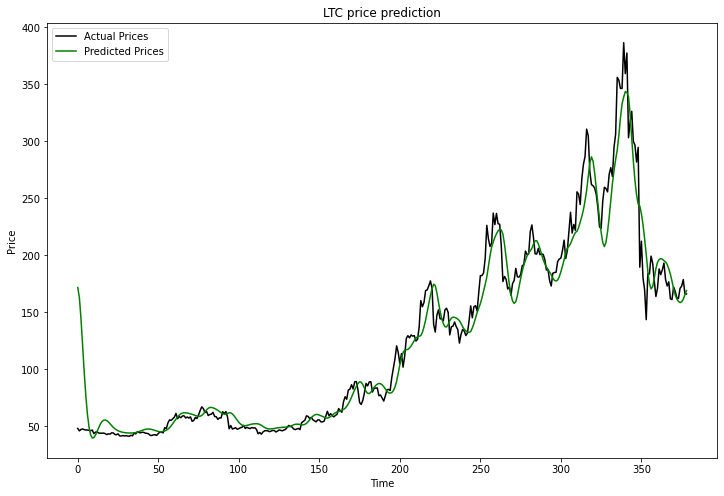

In [10]:
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color="black", label='Actual Prices')
plt.plot(prediction_prices, color="green", label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Predict next day

In [11]:
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[171.64703]]
